In [1]:
# %load notebook_setup.py
#Use %load notebook_setup.py to load these commands at the top of your
#ipython notebook.  Includes running the std_libraries.py file. 

%run std_libraries.py
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook

what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = othera
base directory is C:\Users\BMH_work\github\yeast_esr_expression_analysis
Added C:\Users\BMH_work\github\yeast_esr_expression_analysis to path: 
['C:\\Users\\BMH_work\\github\\yeast_esr_expression_analysis\\scripts', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression\\python37.zip', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression\\DLLs', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression\\lib', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression', '', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression\\lib\\site-packages', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression\\lib\\site-packages\\win32', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression\\lib\\site-packages\\win32\\lib', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression\\lib\\site-packages\\Pythonwin', 'C:\\Users\\BMH_work\\anaconda3\\envs\\yeast_esr_expression

In [15]:
#Load PKA act genes, SC and KL:

#genes activated by PKA inhibition

sc_pkainh_act_genes = pd.read_csv(os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20200608_pkainh_act_SC.csv'), index_col = 0)
kl_pkainh_act_genes = pd.read_csv(os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20200608_pkainh_act_KL.csv'), index_col = 0)

#Load previously created dubious orf file to subtract those genes from SC activated genes
dubious_orfs = pd.read_csv(data_processing_dir + os.path.normpath("genomes/scer_20181114/dubious_orfs.csv"), index_col=0, squeeze=True)

target_sets_dict = {'Scer': {'pkainh_act': (set(sc_pkainh_act_genes.index)-set(dubious_orfs))},
                    'Klac': {'pkainh_act': set(list(kl_pkainh_act_genes.index))}
                   }

# target_sets_dict = {}
# for spec in ['SC', 'KL']:
#     fname = data_processing_dir + os.sep + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/20181203_r1g1_m24_pka_targets_' + spec + '.pkl')
  
#     with open(fname, 'rb') as file:
#         target_sets_dict[spec] = pickle.load(file)

In [ ]:
#For each species

#Load regev data, threshold on induction for PKA related conditions (and for average)

#Load promoters for the species
#calculate STRE percentage for all genes and for 

In [4]:
specs = ['Scer','Smik','Suva', 'Cgla', 'Ncas','Vpol', 'Klac','Lwal','Lklu','Calb','Ylip'] 

stress_genesets = {}
for spec in specs: 
    conds_pka_corr = ['DS/LOG', 'PS/LOG', 'PLAT/LOG', 'heat shock_030', 'heat shock_045']
    thresh = 2.5  #  -2.5  #used 1.8 for DE stress
    #spec_conditions = {}

    #Load regev data
    fname_array_data = os.path.normpath(data_processing_dir + 'regev_data/' + spec + '_growth_stress_norm.csv')  
    spec_data = pd.read_csv(fname_array_data, index_col=0)
    conditions = spec_data.columns
    #spec_conditions[spec] = conditions
    stress_genesets_spec = {}
    for cond in conds_pka_corr: 
        if cond in conditions: 
            stress_genesets_spec[cond] = list(spec_data[spec_data[cond]>thresh].index)
    
    stress_genesets[spec] = stress_genesets_spec
    
        

        
        


<IPython.core.display.Javascript object>


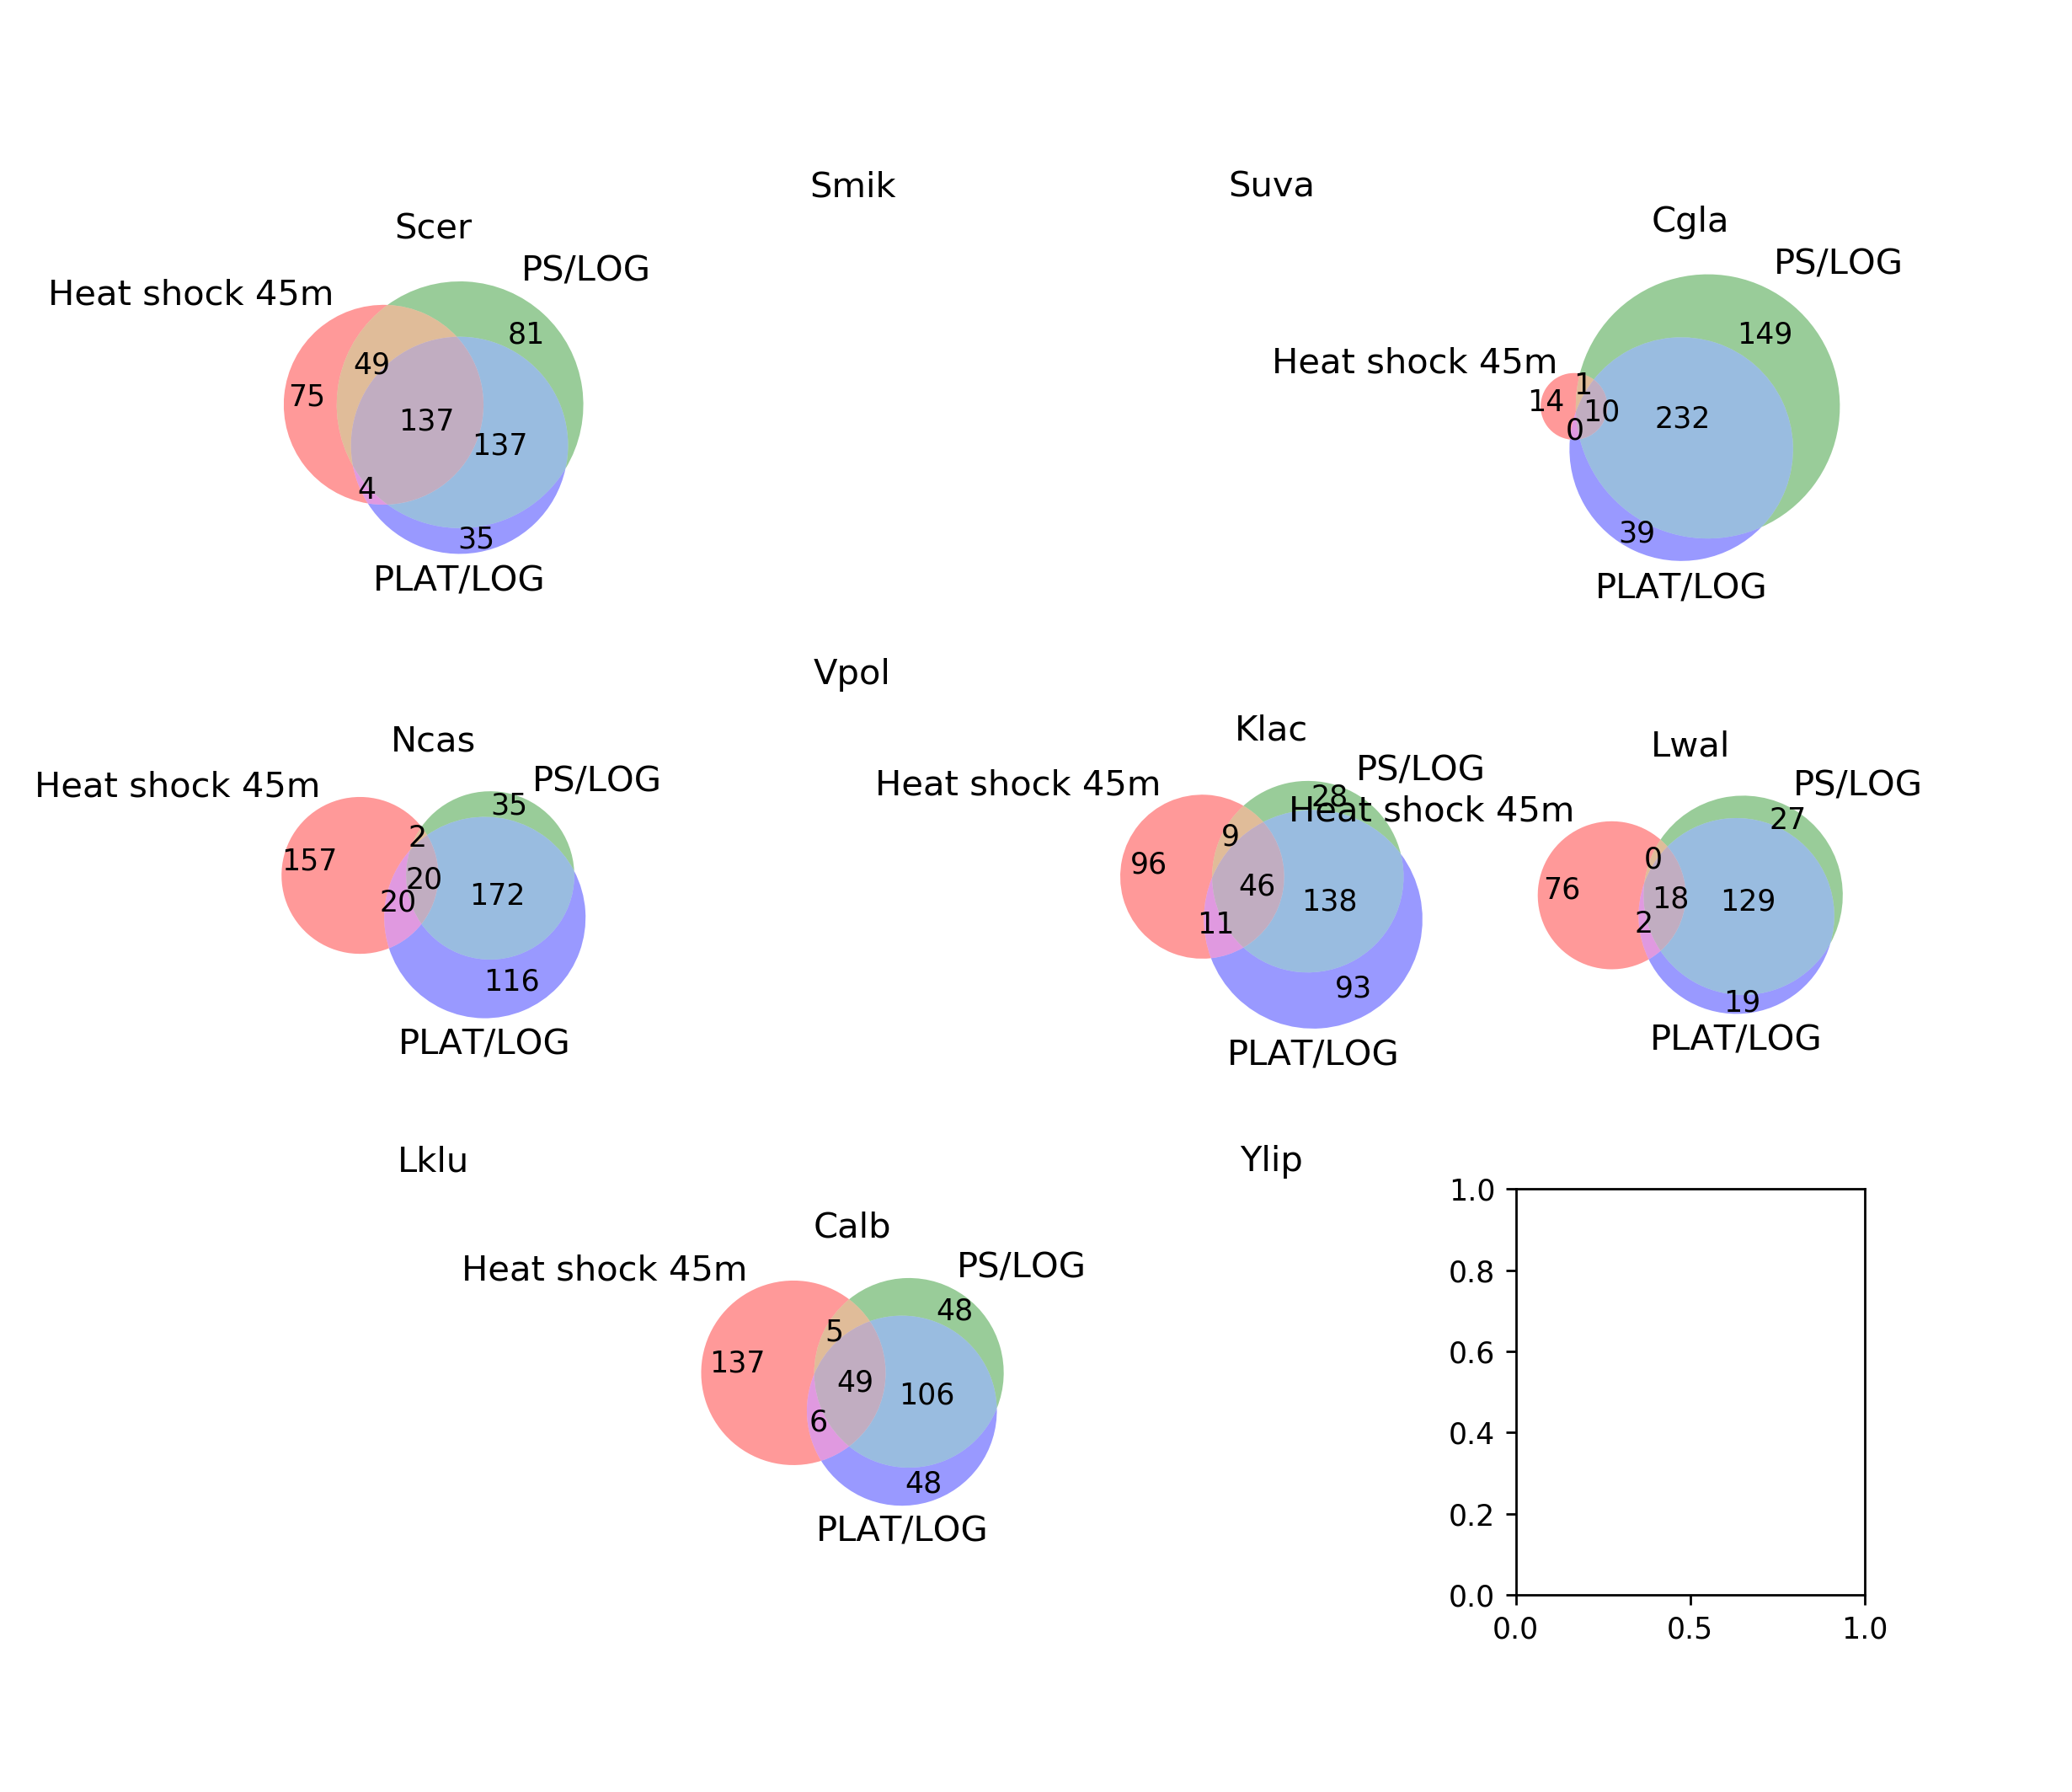

In [5]:
#Visualize overlaps: 

group_params = { 'DS/LOG': ('#23fc64', 'DS/LOG'), 
                'PS/LOG':('#24c153', 'PS/LOG'),
                'PLAT/LOG': ('#209b45', 'PLAT/LOG'),
                'heat shock_030': ('#e89633', 'Heat shock 30m'),
                'heat shock_045': ('#dd8316', 'Heat shock 45m')
               }


fig, axarr = plt.subplots(3,4, figsize=(15,12))
sets_to_view = ['heat shock_045', 'PS/LOG','PLAT/LOG'] #['heat shock_045', 'PS/LOG','PLAT/LOG']
for jj, spec in enumerate(specs): 
    ax = np.ravel(axarr)[jj]
    genesets = stress_genesets[spec]
    if len(set(sets_to_view)-set(genesets.keys()))==0:
        data = []
        labels= []
        colors = []
        for geneset in sets_to_view:
            data.append(set(genesets[geneset]))
            (color,label) = group_params[geneset]
            labels.append(label)
            colors.append(color)
        venn3(data, set_labels = labels, ax=ax)  #set_colors=colors
        
    else: 
        ax.axis("off")
    ax.set_title(spec)
    

In [ ]:
#LWal and LKlu have somewhat small DS genesets, and Lwal overlap doesn't seem particularly strong for that condition.  Ncas and Klac and maybe SUVA have a fairly big PLAT/Log set. All sets do have a strong overlap.  

#Heat shock has good overlap in Scer, but vey low overlap in Ncas, Lwal.  Also Cgla doesn't have a very high heat shock response (maybe as a pathogen?)
#Klac heat shock response also not very big

In [6]:
klsc_pka_genesets

{'sc_pkainh_act': (['YNL305C',
   'YER096W',
   'YIL136W',
   'YOL084W',
   'YIL124W',
   'YLR290C',
   'YLR152C',
   'YGR236C',
   'YDR490C',
   'YBR285W',
   'YPR155C',
   'YGR205W',
   'YDL089W',
   'YDR070C',
   'YER182W',
   'YIL055C',
   'YIL065C',
   'YER037W',
   'YMR252C',
   'YHR171W',
   'YGR149W',
   'YEL070W',
   'YDL183C',
   'YDL085W',
   'YCR011C',
   'YFL014W',
   'YBR148W',
   'YCR061W',
   'YKL187C',
   'YLR331C',
   'YMR169C',
   'YGR066C',
   'YBR128C',
   'YML120C',
   'YNL115C',
   'YNL237W',
   'YNR034W-A',
   'YBR212W',
   'YMR105C',
   'YAL034C',
   'YBR230C',
   'YDR148C',
   'YOR176W',
   'YLR053C',
   'YDL079C',
   'YNL200C',
   'YMR152W',
   'YMR020W',
   'YPL036W',
   'YDR223W',
   'YPR193C',
   'YOR178C',
   'YOL060C',
   'YIL125W',
   'YLR312C',
   'YFL054C',
   'YKL107W',
   'YEL041W',
   'YIL153W',
   'YPR015C',
   'YIL033C',
   'YNR014W',
   'YOR153W',
   'YGL227W',
   'YOL083W',
   'YJL089W',
   'YMR196W',
   'YGL205W',
   'YPR030W',
   'YDL020C',
 

In [ ]:
target_sets_dict[spec]['pkainh_act']

In [ ]:
target_sets_dict[SC_KL_abbrev[spec]][0]['pkainh_act']

In [16]:

#Need to use subset of ohnologs_goi that is defined in y1000 routine.  

#Build promhits data for all genes, genes activated by PKA inhibition (S.Cer, K.Lac), DEpka + orthologs (could also do de stress)

L_prom = 700
output_format = 'full'
motif_dict = {'STRE': ('CCCCT',700), 'TATA': ('TATA[AT]A[AT][AG]',700), 'PDS': ('AGGGAT',700)} 
#motif_dict = {'STRE': 'CCCCT', 'TATA': 'TATA[AT]A[AT][AG]', 'PDS': 'AGGGAT'} 
sequence_context = 2  

specs = ['Scer','Smik','Cgla','Ncas','Vpol', 'Klac','Lwal','Lklu']  #'Smik', 'Suva','Calb','Ylip' #will take some work to map these from regev to current data


# #Might not need to break down by pre/post
# spec_order_post_WGH = ['Scer','Smik','Suva', 'Cgla', 'Ncas','Vpol']  #shoud add in 'Skud', 'Kafr','Knag','Ndai','Tbla','Tpha'
# spec_order_pre_WGH = ['Klac','Lwal','Lklu','Calb','Ylip']  #Should add K.Lac.  others not in YGOB - might be able to get Calb promoters fairly easily

# #spec order, level, level_sep
# spec_sets = {'Post WGH low' : (spec_order_post_WGH, 'low','_'),
#              'Post WGH high' : (spec_order_post_WGH, 'high','_'),
#              'Pre WGH' : (spec_order_pre_WGH, '', '')
#             }
# #each PromHits object will have an average value, plot it in a barplot. 

# prom_hits = {}
# ancestor_to_genes = {}
# # for spec_set_name, (spec_set, level, level_sep) in spec_sets.items(): 
# #     ## make sure I use level and level_sep - otherwise could just have sc_genename_col as the thing to unpack

# #     prom_hits_subset= {}
# #     ancestor_to_genes_level= {}
# # for spec in spec_set: 
# # print(spec)

prom_hits = {}

for spec in specs:

    stress_genesets_spec = stress_genesets[spec]

    #load all promoters for the species
    specs_long = {'Calb': 'candida_albicans'}
    if spec =='Calb':
        promoter_dir = data_processing_dir + os.path.normpath('promoter_phylogeny/promoter_sets/' + specs_long[spec])
        all_promoters_fname = os.path.normpath(promoter_dir + '/all_promoters.fasta')
    else: 
        promoter_dir = data_processing_dir + os.path.normpath('promoter_phylogeny/promoter_sets/' + spec)
        all_promoters_fname = os.path.normpath(promoter_dir + '/all_promoters_' + str(L_prom) + '.fasta')
    all_promoters = SeqIO.to_dict(SeqIO.parse(all_promoters_fname, "fasta"))  

    prom_set_names = ['all'] + [cond for cond in stress_genesets_spec.keys()]
    SC_KL_abbrev = {'Scer':'SC', 'Klac':'KL'}
    if spec in {'Scer', 'Klac'}: 
        prom_set_names = prom_set_names + ['pka_inh']
        pkainh_act_genes = target_sets_dict[spec]['pkainh_act'] #target_sets_dict[SC_KL_abbrev[spec]][0]['pkainh_act']

    #all promoters, pka_inhibition (SC,KL only), DEpka orthologs, build PromHits object

    #Identify genenames to extract
    prom_hits_spec = {}
    for prom_set_name in prom_set_names: 
        print(prom_set_name)
        if prom_set_name=='all':
            gene_list = all_promoters.keys() #prom_hits_spec_level[prom_set_name]=io_library.exact_promoter_scan_from_fasta(all_promoters_fname, motif_dict, output_format = output_format, sequence_context = sequence_context, L_prom = L_prom) 
        elif prom_set_name=='pka_inh':
            gene_list = pkainh_act_genes
        else: 
            gene_list = stress_genesets_spec[prom_set_name]

            if spec=='Lwal':
                gene_list_update=[]
                for gene in gene_list:
                    gene_list_update.append('Kwal_' + gene.split('Kwal')[1])
                gene_list = gene_list_update

            if spec in ['Ncas', 'Klac', 'Smik']: 
                orth_dir = data_processing_dir + 'ortholog_files_regev' + os.sep
                orth_lookup = yeast_esr_exp.read_orth_lookup_table(spec + '_regev', spec + '_YGOB', orth_dir)

                gene_list_update = []
                for gene in gene_list:
                    if gene in orth_lookup.keys():
                        genes_YGOB = orth_lookup[gene]
                        if len(genes_YGOB)==1:
                            gene_YGOB=genes_YGOB[0]
                            if gene_YGOB != 'NONE':
                                gene_list_update.append(gene_YGOB)
                            else: 
                                print('No ortholog mapping from regev name to YGOB: ' + gene)
                        else: 
                            print('More than one mapping from regev name to YGOB: ' + gene)
                    else: 
                        print('No line in regev to YGOB mapping file for: ' + gene)
                gene_list = gene_list_update

        #Get promoter counts 
        prom_hits_spec[prom_set_name] = yeast_esr_exp.exact_promoter_scan_genelist_dict(gene_list, all_promoters, motif_dict, output_format = output_format, sequence_context = sequence_context)
    prom_hits[spec]=prom_hits_spec
# #ancestor_to_genes[spec_set_name]=ancestor_to_genes_level
     

all
DS/LOG
TC20762 not in promoter_dict
PS/LOG
TC20762 not in promoter_dict
TC21215 not in promoter_dict
TC21605 not in promoter_dict
PLAT/LOG
TC20762 not in promoter_dict
TC21215 not in promoter_dict
TC21605 not in promoter_dict
heat shock_030
TC20762 not in promoter_dict
heat shock_045
TC20762 not in promoter_dict
pka_inh
all
DS/LOG
No line in regev to YGOB mapping file for: smik1003-g1.1
No line in regev to YGOB mapping file for: smik1009-g1.1
No line in regev to YGOB mapping file for: smik1026-g1.1
No line in regev to YGOB mapping file for: smik1027-g1.1
More than one mapping from regev name to YGOB: smik1113-g1.1
No line in regev to YGOB mapping file for: smik1207-g1.1
More than one mapping from regev name to YGOB: smik125-g1.1
No line in regev to YGOB mapping file for: smik1413-g1.1
No line in regev to YGOB mapping file for: smik15-g5.1
No line in regev to YGOB mapping file for: smik1578-g1.1
More than one mapping from regev name to YGOB: smik1584-g1.1
No line in regev to YGOB ma

DS/LOG
No line in regev to YGOB mapping file for: Scas340.1
No line in regev to YGOB mapping file for: Scas478.3
No line in regev to YGOB mapping file for: Scas500.1
No line in regev to YGOB mapping file for: Scas552.0d
No line in regev to YGOB mapping file for: Scas565.10
No line in regev to YGOB mapping file for: Scas600.1
No line in regev to YGOB mapping file for: Scas705.36
PS/LOG
No line in regev to YGOB mapping file for: Scas340.1
No line in regev to YGOB mapping file for: Scas375.2d
No line in regev to YGOB mapping file for: Scas377.1
No line in regev to YGOB mapping file for: Scas478.3
No line in regev to YGOB mapping file for: Scas500.1
No line in regev to YGOB mapping file for: Scas552.0d
No line in regev to YGOB mapping file for: Scas565.10
No line in regev to YGOB mapping file for: Scas565.2
No line in regev to YGOB mapping file for: Scas600.1
No line in regev to YGOB mapping file for: Scas623.4
No line in regev to YGOB mapping file for: Scas625.17d
No line in regev to YGOB

KLLA0D15477r not in promoter_dict
EBG00000981576 not in promoter_dict
EBG00000982260 not in promoter_dict
KLLA0C17908r not in promoter_dict
all
DS/LOG
PS/LOG
PLAT/LOG
heat shock_030
heat shock_045
all
DS/LOG
PS/LOG
PLAT/LOG


In [17]:
# spec_order_post_WGH = ['Scer','Smik','Skud','Suva', 'Cgla', 'Kafr','Knag','Ndai','Ncas','Tbla','Tpha','Vpol']
# spec_order_pre_WGH = specs_ordered_fig2[1:]
# ['Torulaspora_delbrueckii',
#  'Zygosaccharomyces_bailii',
#  'Zygosaccharomyces_rouxii',
#  'Zygotorulaspora_florentina',
#  'Metschnikowia_hawaiiensis',
#  'Kluyveromyces_lactis',
#  'Kluyveromyces_marxianus',
#  'Eremothecium_gossypii',
#  'Debaryomyces_hansenii',
#  'Hanseniaspora_vineae',
#  'Cyberlindnera_jadinii',
#  'Wickerhamomyces_anomalus',
#  'Ascoidea_rubescens',
#  'Komagataella_pastoris']

# spec_sets = [('Post WGH low', spec_order_post_WGH), 
#              ('Post WGH high', spec_order_post_WGH), 
#              ('Pre WGH', spec_order_pre_WGH)]

# gene_groups = ['all','DEpka']

# motif_calcs = {}
# for spec_set, spec_list in spec_sets:
#     motif_calcs[spec_set] = {}
#for spec in spec_list: 

ranges = {'STRE': 700, 'TATA': 300}

motif_calcs = {}
for spec in specs:
    print(spec)
    motif_calcs[spec] = {}
    prom_hits_spec = prom_hits[spec]
    for gene_group in prom_hits_spec.keys():
        prom_hits_data = prom_hits_spec[gene_group]

        #maybe not necessary
        prom_hits_data_subset = prom_hits_data

        motif_calcs[spec][gene_group] = yeast_esr_exp.PromHits(prom_hits_data_subset,motif_dict, prefix = '')
        motif_calcs[spec][gene_group].STRE_TATA_combined(ranges)
        #pct = STRE_TATA_combined(ranges, prom_hits_data_subset)
        
        #motif_calcs[spec][gene_group]['pct']['STRE_TATA']= pct

Scer
Smik
Cgla
Ncas
Vpol
Klac
Lwal
Lklu


<IPython.core.display.Javascript object>


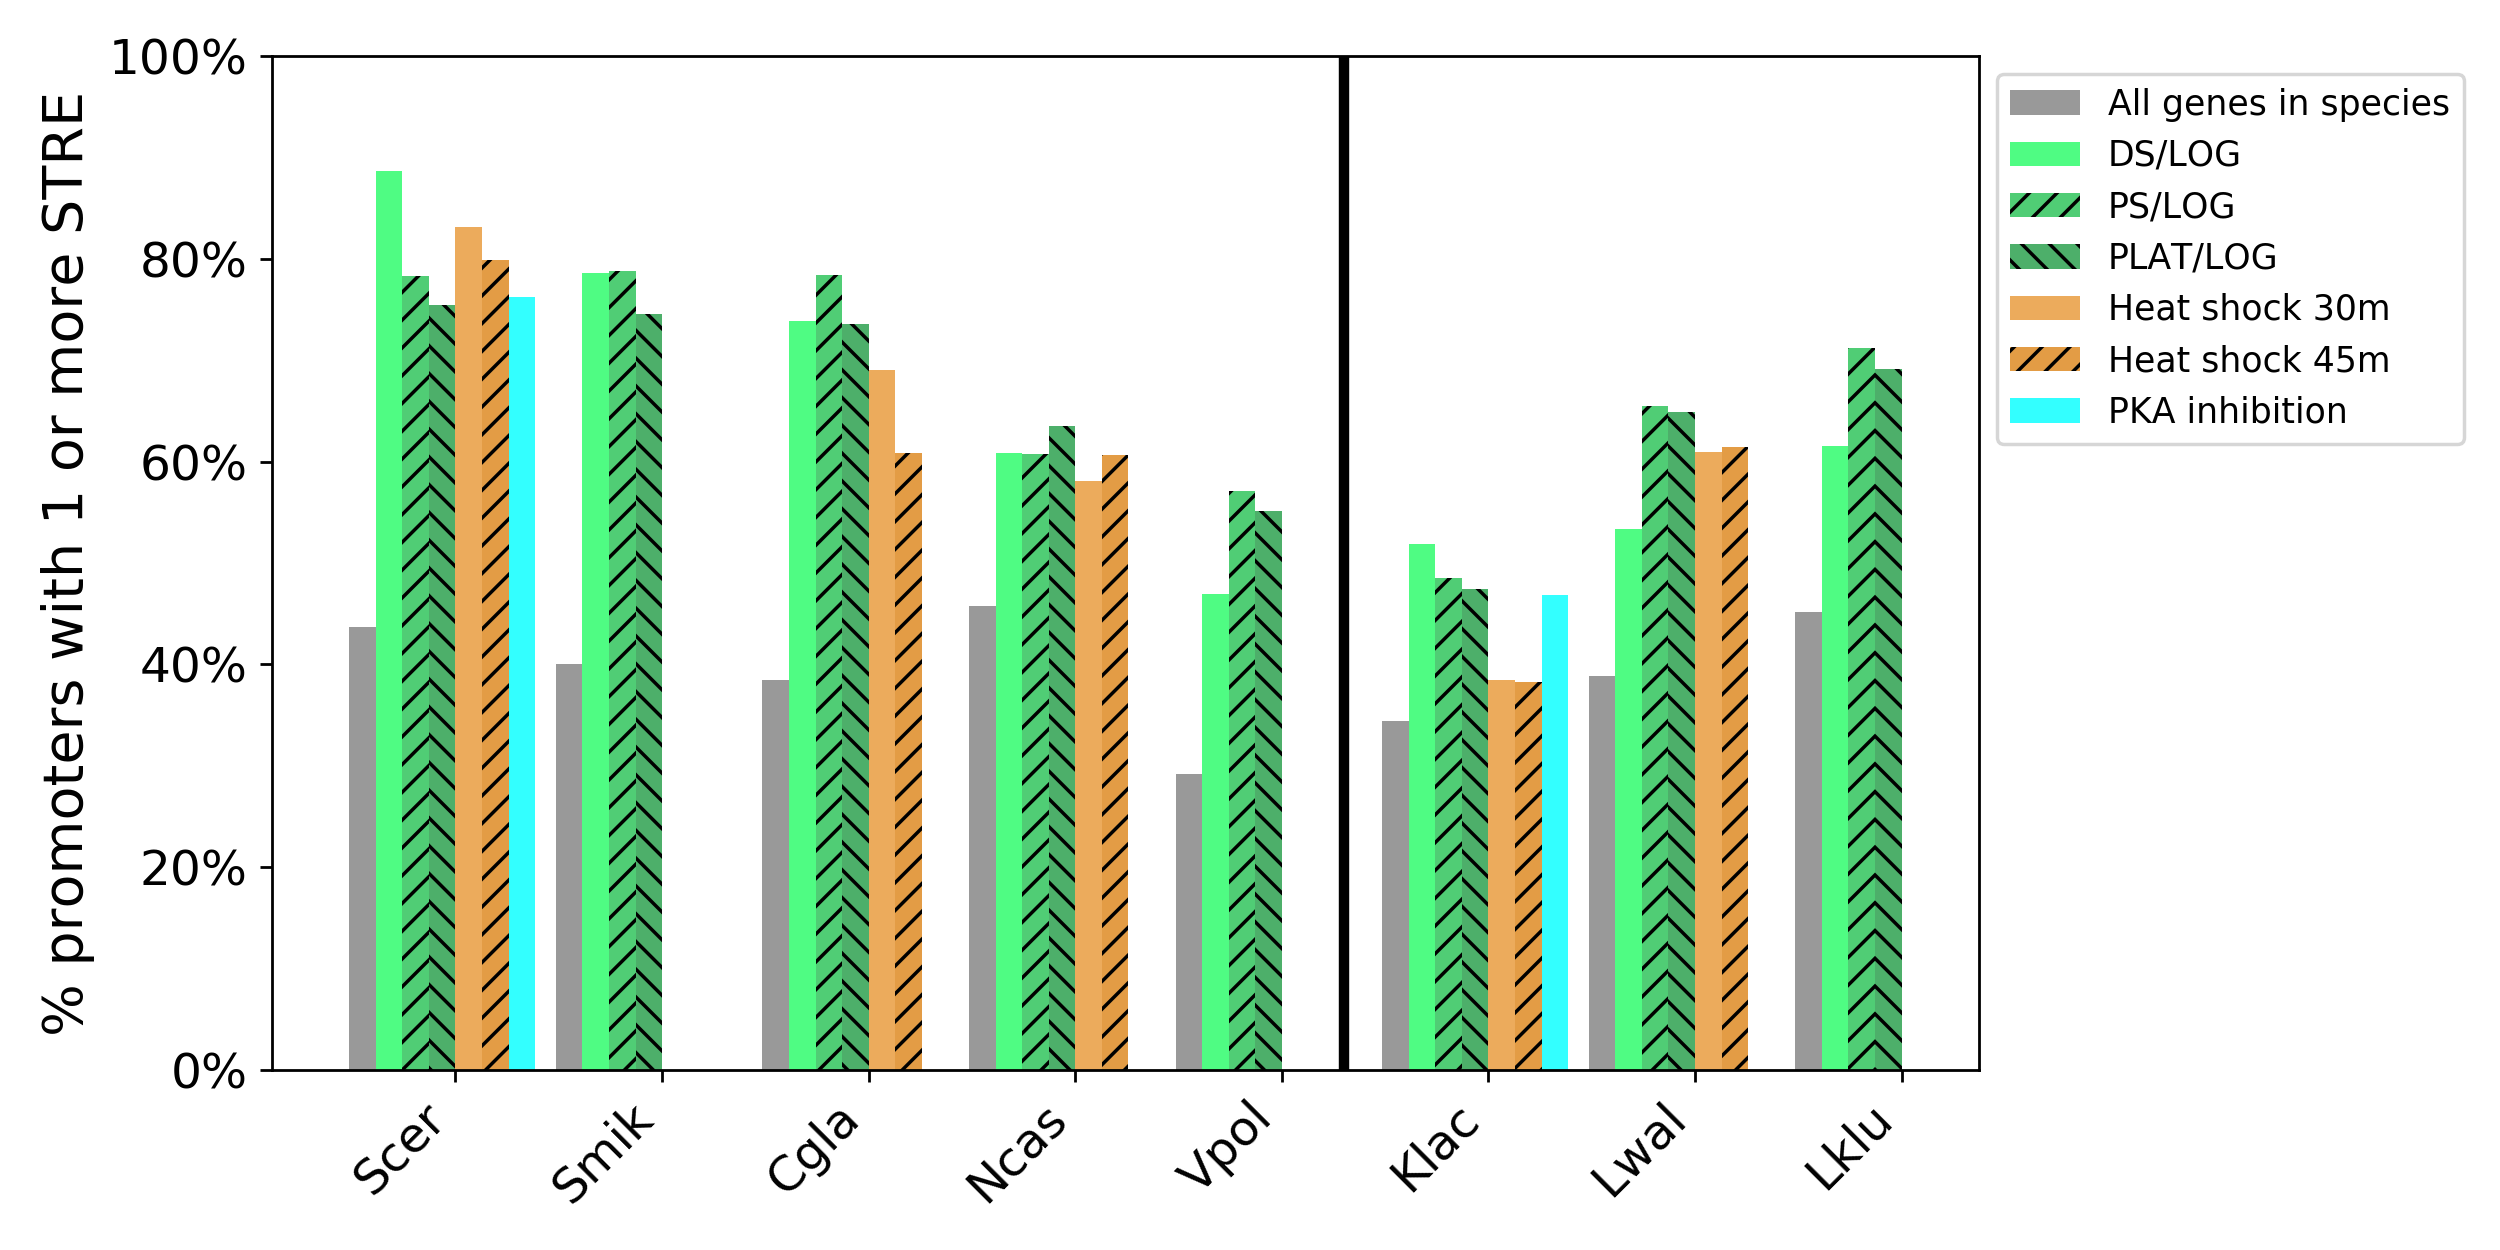

In [22]:
#Plot percentage of STREs in low and high as you go away from S.Cer

motif_name = 'STRE' #'STRE_TATA'

fig_pct, ax_pct = plt.subplots(1,1, figsize=(10,5))
groups = ['all'] + conds_pka_corr + ['pka_inh']
bw = (1-0.1)/len(groups)
opacity = 0.8

# #(color, legend_label, hatch)
group_params = {'all':('grey','All genes in species',''), 
                'pka_inh': ('cyan','PKA inhibition',''), 
                'DS/LOG': ('#23fc64', 'DS/LOG',''), 
                'PS/LOG':('#24c153', 'PS/LOG','///'),
                'PLAT/LOG': ('#209b45', 'PLAT/LOG','\\\\\\'),
                'heat shock_030': ('#e89633', 'Heat shock 30m', ''),
                'heat shock_045': ('#dd8316', 'Heat shock 45m', '///')
               }

index = {group:[] for group in groups}
data = {group:[] for group in groups}
label_order = []


#pre WGH Species
for jj,spec in enumerate(specs): #dict(spec_sets)['Pre WGH']: 
    for kk, group in enumerate(groups): 
        label_order.append(spec)        
        if group in motif_calcs[spec].keys():
            index[group].append(jj+kk*bw)
            data[group].append(motif_calcs[spec][group]['pct'][motif_name])


for group in groups: 
    (color, legend_label, hatch) = group_params[group]
    pct_plot = ax_pct.bar(index[group],data[group], bw,
                 alpha=opacity,
                 color=color,
                 hatch = hatch,
                 label=legend_label) 
                 #bottom = bottom)

# for subset_name in ['all', 'low','high','Pre WGH']: 
#     subset_data = data[subset_name]
    
#     color, legend_label = group_params[subset_name]
                
#     pct_plot = ax_pct.bar(index[subset_name],subset_data, bw,
#                  alpha=opacity,
#                  color=color,
#                  label=legend_label) 
#                  #bottom = bottom)

        
black_lines = []
# yellow_lines = []
black_lines_set = {'Vpol'} #,'Torulaspora_franciscae','Lachancea_fantastica_nom_nud'}
# yellow_lines_set = {'Zygosaccharomyces_bisporus', 'Kluyveromyces_lactis', 'Eremothecium_gossypii'}

for jj,label in enumerate(specs):
    if label in black_lines_set:
        black_lines.append(jj+0.75)
#     elif label in yellow_lines_set:
#         yellow_lines.append(jj+0.75)
        
# ax_pct.vlines(yellow_lines, ymin = 0, ymax = 1.0, colors = 'yellow',linewidth=3)
ax_pct.vlines(black_lines, ymin = 0, ymax = 1.0, colors = 'black',linewidth=3)
ax_pct.set_xticklabels(specs, rotation='45', ha='right', fontdict={'fontsize':14})
ax_pct.set_xticks(np.array(index['all'])+0.45)
ax_pct.set_ylim(0,1.0)
pct_ticks = ax_pct.get_yticks()
pct_ticklabels = ['{:,.0%}'.format(tick) for tick in pct_ticks] 
ax_pct.set_yticklabels(pct_ticklabels, fontdict={'fontsize':14})

ax_pct.set_ylabel('% promoters with 1 or more ' + motif_name, fontdict={'fontsize':16})
#ax_pct.set_ylabel('Pct promoters with >1 STRE in 700bp and >1 TATA in 300bp')
ax_pct.legend(loc = 'upper left', bbox_to_anchor = (1.0,1.0))
plt.tight_layout()


fig_pct.savefig(figsave_dir + motif_name + '_pct_stress_conservation.svg',bbox_inches='tight')

In [20]:
#Significance calculations (for above figure)


motif_name = 'STRE'

for spec in specs:
    print(spec)
    #spec = 'Cgla'

    all_motif = motif_calcs[spec]['all']['hits'][motif_name]
    all_no_motif = motif_calcs[spec]['all']['total']-all_motif

    for cond in list(set(motif_calcs[spec].keys())-{'all'}):
        #cond = 'PLAT/LOG'

        cond_motif =  motif_calcs[spec][cond]['hits'][motif_name]
        cond_no_motif = motif_calcs[spec][cond]['total']-cond_motif

        oddsratio, pvalue = stats.fisher_exact([[cond_motif, cond_no_motif], [all_motif-cond_motif, all_no_motif-cond_no_motif]])
        print('Condition: {}, pvalue: {:0.2e}'.format(cond, pvalue))

Scer
Condition: PS/LOG, pvalue: 4.21e-48
Condition: heat shock_045, pvalue: 1.18e-34
Condition: DS/LOG, pvalue: 2.40e-36
Condition: PLAT/LOG, pvalue: 3.90e-31
Condition: heat shock_030, pvalue: 1.16e-32
Condition: pka_inh, pvalue: 1.79e-57
Smik
Condition: DS/LOG, pvalue: 4.95e-11
Condition: PS/LOG, pvalue: 5.46e-16
Condition: PLAT/LOG, pvalue: 9.33e-14
Cgla
Condition: PS/LOG, pvalue: 2.34e-60
Condition: heat shock_045, pvalue: 3.18e-02
Condition: DS/LOG, pvalue: 1.18e-22
Condition: PLAT/LOG, pvalue: 1.14e-33
Condition: heat shock_030, pvalue: 1.07e-09
Ncas
Condition: PS/LOG, pvalue: 1.17e-05
Condition: heat shock_045, pvalue: 4.27e-05
Condition: DS/LOG, pvalue: 9.62e-03
Condition: PLAT/LOG, pvalue: 2.67e-10
Condition: heat shock_030, pvalue: 4.70e-04
Vpol
Condition: DS/LOG, pvalue: 7.72e-04
Condition: PS/LOG, pvalue: 1.99e-14
Condition: PLAT/LOG, pvalue: 3.43e-13
Klac
Condition: PS/LOG, pvalue: 2.71e-05
Condition: heat shock_045, pvalue: 3.60e-01
Condition: DS/LOG, pvalue: 2.74e-05
Con